# Calibration

## 0. Import packages

In [1]:
%matplotlib inline

import cv2
import matplotlib.pyplot

import openalea.phenomenal.data as phm_data
import openalea.phenomenal.display as phm_display
import openalea.phenomenal.calibration as phm_calib

## 1. Detect chessboard corners in the images

### 1.0 Load Images

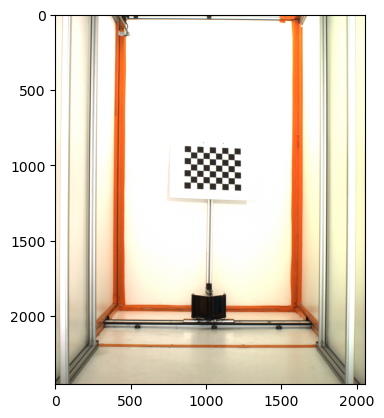

In [2]:
plant_number = 1
chessboard_images = phm_data.chessboard_images("data/plant_1")[0]
phm_display.show_image(chessboard_images['side'][42])

### 1.1 Create chessboard object

Create chessboard object with square size and shape of chessboard

In [3]:
square_size_of_chessboard = 47 # In mm
square_shape_of_chessboard = (8, 6) # (8 square x 6 square on chessboard)

# BUILD CHESSBOARD OBJECT
chessboard = phm_calib.Chessboard(square_size_of_chessboard, 
                                  square_shape_of_chessboard)

# DISPLAY IT
print(chessboard)

Chessboard Attributes :
Square size (mm): 47
Shape : (8, 6)



### 1.2 Detect corners from images

In [4]:
for id_camera in chessboard_images:
    for angle in chessboard_images[id_camera]:
        im = chessboard_images[id_camera][angle]
        found = chessboard.detect_corners(id_camera, angle, im, check_order=False)
        print("Angle {} - Chessboard corners {}".format(angle, "found" if found else "not found"))

Angle 42 - Chessboard corners found


### 1.3 Display chessboard corners on images

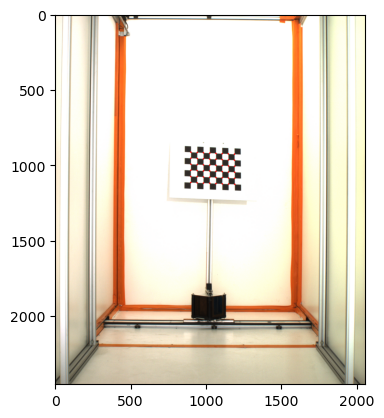

In [5]:
angle = 42
img = chessboard_images["side"][angle].copy()

# DRAW RED POINT ON IMAGE CORNERS POSITION
points_2d = chessboard.image_points[id_camera][angle].astype(int)
for x, y in zip(points_2d[:, 0, 1], points_2d[:, 0, 0]):
    cv2.circle(img, (y, x), 5, (255, 0, 0), -1)

phm_display.show_image(img)

### 2.4 Dump & load

In [6]:
chessboard.dump('chessboard.json')

In [7]:
chessboard = phm_calib.Chessboard.load('chessboard.json')

## 2. Multi-camera calibration

### 2.0 Load chessboard object with all corners points

In [8]:
# Load image points
image_points = phm_data.image_points("data/plant_1")

### 2.1 Do calibration

In [27]:
# setup calibration layout
calibrator = phm_calib.Calibrator(south_camera=('side', 90, 5500),
                            targets={'target_1': (45, 48), 'target_2': (45, 48 + 180)},
                            chessboards={'target_1': (47, 8, 6),
                                         'target_2': (47, 8, 6)})
calibrator.load_image_points(image_points)

#calibrate
calibration = calibrator.calibrate(verbose=False)

# Error of reprojection (in pixel distance)
print(calibration.calibration_statistics['mean_error'])

0.24072051939860584


### 2.2 Dump

In [28]:
# Dump
calibration.dump('calibration_camera_side.json')

### 2.6 Viewing calibration result

#### 2.6.2 Show chessboard image with corners projection

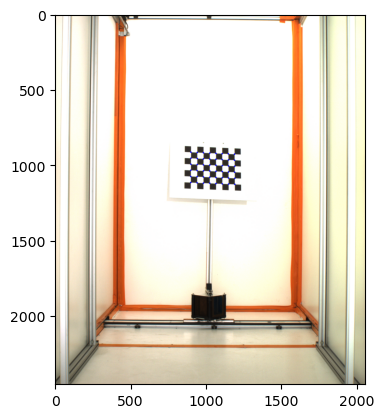

In [35]:
angle = 42
circle_radius = 5
img = chessboard_images['side'][angle].copy()

# RED POINTS ARE POINTS POSITIONS DETECTED BY OPENCV CHESSBOARD DETECTION 
pt_2d = image_points['target_1'].get_corners_2d('side')[42].astype(int)
for x, y in pt_2d:
    cv2.circle(img, (x, y), circle_radius, (255, 0, 0), -1)

# BLUE POINTS ARE POINTS POSITIONS PROJECTED BY CALIBRATION CHESSBOARD COMPUTATION
points_2d = calibration.get_target_projected('side', 'target_1', 42).astype(int)
for x, y in pt_2d:
    cv2.circle(img, (x, y), circle_radius, (0, 0, 255), -1)
phm_display.show_image(img)